# Calculating the Volatility smile

The volatility smile is related to the fact that options at different strikes have different levels of implied volatility. Since volatility is the only parameter which is unobserved (in Black-Scholes) it is an important concept to grasp. In this article we will calculate the implied volatility for options at different strikes using Scipy. To see a from scratch implementation of calculating implied volatility using Newton's method see here. 

In the notebook on binary options we observed from market data that the volatility is not constant from market prices and this implies a heavier tail probability that the log-normal distribution that the Black-Scholes model assumes.

The plot below is the implied volatility curve for Apple options:

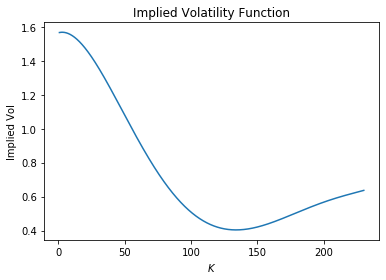

We can look at calculating implied volatility as a minimize problem. Below we minimize the absolute difference between the market price and the Black-Scholes price. We have bounded this minimization such that the volatility is less than 600%. This number was chosen without much thought, so feel free to change it or let me know if it should be higher/lower.

Let $V$ below be the value of a European call or put option:

$$
\text{implied_volatility (IV)} = \underset{\sigma \in (0,6]}{\arg\min} \lvert V_{market} - V_{BS}(S,K,T,r,\sigma) \rvert
$$

To complete the logic above we will use Scipy's `minimize_scalar` function which uses Brent's method underneath the hood. This method seems to be more robust than the Newton-Raphson implementation shown previously. This is perhaps due to that fact that vega will be close to zero for out of the money options. 

In [1]:
from getOptionData_implVol import get_data
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt

### Black-Scholes implementation

In [2]:
def BS_CALL(S, K, T, r, sigma):
    N = norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    N = norm.cdf
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

### Compute IV

In [3]:
def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,10), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,10),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")

#### Let's test

The small example below tests that the implied volatility function calculates things as expected. This function is quite fast which is good and it seems to work correctly. 

In [4]:
###testing implied vol function####
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.45

C = BS_CALL(S, K, T, r, sigma)
iv = implied_vol(C, S, K, T, r)
print("True volatility:", sigma)
print("Implied volatility", iv)

True volatility: 0.45
Implied volatility 0.4499996144569838


### Real life Example

Let's try calculating the implied volatility for Tesla options. Luckily Yahoo Finance provides a estimate of implied volatility also so we have something to benchmark on. For simplicity we assume interests rates are zero. This isn't such a big deal since at the time of writing interests rates are as close to zero as is possible. I have found the calculated volatility to be more accurate when using the ask price from Yahoo Finance, but feel free to check the bid or the mid also. 

In [18]:
ticker = "AAPL"
calls = get_data(ticker)
calls

,Contract Name,maturity_date,Maturity_days,Maturity_years,Strike,Last Price,Bid,Ask,Mid,Change,% Change,impl_vol_yahoo,impl_vol_yahoo_float
0,AAPL240216C00050000,2024-02-16,4,0.015686,50.0,139.55,138.50,139.15,138.825,1.60,+1.16%,476.56%,4.7656
1,AAPL240216C00055000,2024-02-16,4,0.015686,55.0,140.25,133.60,134.25,133.925,0.00,-,373.44%,3.7344
2,AAPL240216C00060000,2024-02-16,4,0.015686,60.0,127.80,128.65,129.25,128.950,0.00,-,359.38%,3.5938
3,AAPL240216C00065000,2024-02-16,4,0.015686,65.0,117.06,120.50,121.35,120.925,0.00,-,0.00%,0.0000
4,AAPL240216C00070000,2024-02-16,4,0.015686,70.0,116.53,118.20,119.60,118.900,0.00,-,290.63%,2.9063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,AAPL260618C00280000,2026-06-18,857,3.360784,280.0,5.90,5.60,6.40,6.000,0.00,-,24.37%,0.2437
47,AAPL260618C00285000,2026-06-18,857,3.360784,285.0,5.00,5.00,5.55,5.275,0.00,-,23.93%,0.2393
48,AAPL260618C00290000,2026-06-18,857,3.360784,290.0,4.70,4.60,5.00,4.800,0.37,+8.55%,23.80%,0.2380
49,AAPL260618C00300000,2026-06-18,857,3.360784,300.0,3.84,3.50,4.05,3.775,0.38,+10.98%,23.58%,0.2358


0
139.55
1
140.25
2
127.8
3
117.06
4
116.53
5
113.41
6
108.05
7
105.19
8
100.75
9
93.15
10
88.15
11
83.05
12
78.1
13
73.1
14
68.1
15
64.6
16
58.09
17
53.19
18
48.17
19
44.46
20
39.03
21
34.0
22
31.5
23
28.88
24
26.2
25
24.0
26
21.45
27
19.1
28
16.56
29
14.05
30
11.6
31
9.1
32
6.75
33
4.5
34
2.71
35
1.37
36
0.6
37
0.26
38
0.12
39
0.07
40
0.03
41
0.03
42
0.01
43
0.01
44
0.01
45
0.01
46
0.01
47
0.01
48
0.01
49
0.01
50
0.01
51
0.01
52
0.01
53
0.01
54
0.01
55
0.01
56
0.01
57
0.01
58
0.01
59
0.01
60
0.01
61
0.01
62
0.01
63
0.01
64
0.01
65
0.01
66
0.01
67
0.03
68
0.01
69
89.33
70
83.5
71
75.0
72
62.1
73
50.0
74
43.32
75
37.0
76
34.5
77
29.23
78
24.1
79
18.9
80
15.25
81
9.41
82
5.19
83
2.13
84
0.64
85
0.2
86
0.08
87
0.04
88
0.01
89
0.01
90
0.01
91
0.01
92
0.01
93
0.02
94
0.01
95
0.01
96
0.01
97
0.01
98
0.01
99
88.3
100
84.86
101
47.65
102
49.25
103
44.25
104
38.49
105
33.7
106
30.34
107
24.78
108
19.53
109
14.64
110
9.98
111
5.85
112
2.82
113
1.12
114
0.41
115
0.17
116
0.08
117
0.05
118
0.03
1

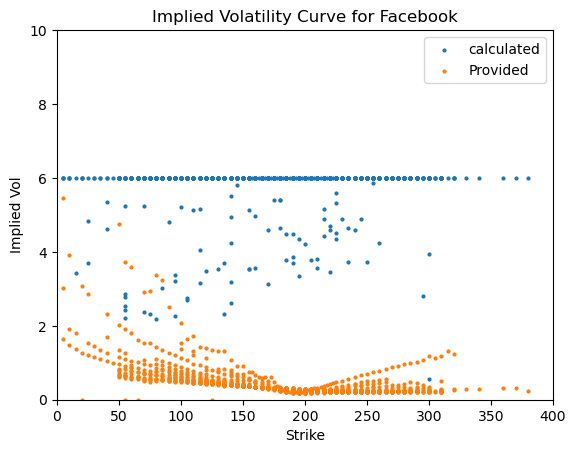

In [25]:
ivs = [] 
for row in calls.itertuples(index=False):
    iv = implied_vol(row[7], row[5], row[4], row[3], 0.00)
    
    ivs.append(iv)
    counter = counter + 1

plt.scatter(calls["Strike"], ivs, label='calculated', s=4)
plt.scatter(calls["Strike"], calls["impl_vol_yahoo_float"], label='Provided', s=4)
plt.xlabel('Strike')
plt.ylabel('Implied Vol')
plt.title('Implied Volatility Curve for Facebook')
plt.xlim([0, 400])
plt.ylim([0, 10])
plt.legend() 

In [21]:
ivs

[5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.997344250435435,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499338889,
 5.99999499